# Motor Calculations

Purpose: Verify the predictions for the performance of the motor & propeller against the predictions from simplified theory.

In [2]:
%config InlineBackend.figure_formats = ['svg']
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pint import UnitRegistry 
from propeller_performance_parser import parse_propeller_performance
from scipy import optimize, interpolate, integrate
u = UnitRegistry() # for unit conversions

Start by opening the test data to make some plots.

In [5]:
df = pd.read_csv("resources/motor_data_jan16.csv")
df['P'] = df['Voltage (V)'] * df['Current (A)']
df['P (kW)'] = df['P'] * 1e-3
df['Throttle'] = (df['PWM (µs)'] - 1000 ) * 0.1
print(df.columns)

Index(['PWM (µs)', 'Thrust (N)', 'Voltage (V)', 'Current (A)', 'P', 'P (kW)',
       'Throttle'],
      dtype='object')


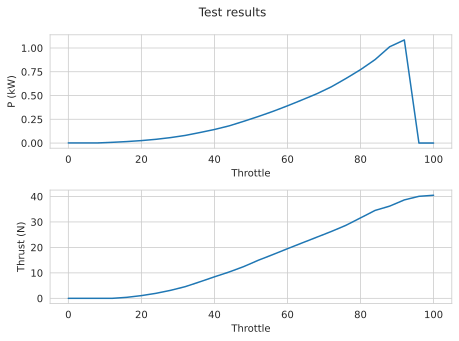

In [12]:
sns.set_style(style="whitegrid")
ax0 = plt.subplot(211)
sns.lineplot(df, x="Throttle", y="P (kW)")
plt.subplot(212, sharex=ax0)
# sns.lineplot(df, x="Current (A)", y="Thrust (N)")
sns.lineplot(df, x="Throttle", y="Thrust (N)")
plt.tight_layout()
plt.gcf().suptitle("Test results")
plt.tight_layout()

# Motor and Prop characteristics

Motor:
- Name: C-42-60-06 600
- Kv: 600 rpm/V
- Kt: 2.253 InOz/A = 15.95 mN-m/A
- Rm @ 20C: 0.027 Ω
- low load current: 3.47 A @ 14 V
- Max current: 75 A
- Max power: 1.6 kW (1.3 kW?)

Note about voltage measurement -- this is the measurement before the ESC drop 

Propeller:
- Name: APC
- Diameter: 12 in = 0.305m
- Pitch: 8 in = 20.3 cm
- Suggested prop constants:
- Kt = 1.026
- Kp = 0.6
- n_blades: 2

In [16]:
# A start at approximating the motor performance analytically
# The "throttle" is a voltage input to the motor
# can get power by multiplying torque and rpm
def c_42_60_06_torque(throttle, rpm):   
    Kv = 600 # rpm / v
    Kt = 15.95e-3 # N-m / A
    Rm = 0.027 # ohm
    return Kt / Rm * (throttle - rpm / Kv) # Stevens 8.4-6

In [17]:
# manufacturer provided information about prop
df_manufacturer = pd.DataFrame(parse_propeller_performance('resources/PER3_12x8.dat'))
# sns.lineplot(df_manufacturer[df_manufacturer['V (mph)'] == 0], x = 'rpm', y = 'Thrust (N)')
# plt.title("Manufacturer rated thrust, 0 speed")
df_manufacturer[df_manufacturer['V (mph)'] == 0]
df_manufacturer['V (m/s)'] = df_manufacturer['V (mph)'] * (u('mph')/u('m/s')).to("").magnitude

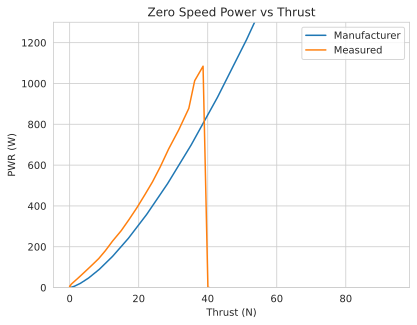

In [20]:
# plot manufacturer expectation against measured results
# the manufacturer power is the power they expect to be required to drive the prop at zero speed
df_m_0s = df_manufacturer[df_manufacturer['V (mph)'] == 0]
sns.lineplot(df_m_0s, y='PWR (W)', x="Thrust (N)", label="Manufacturer")
sns.lineplot(df, y="P", x="Thrust (N)", label="Measured")
plt.ylim(0, 1300)
plt.title("Zero Speed Power vs Thrust")
plt.legend()

Text(0, 0.5, '$\\eta_m$ [-]')

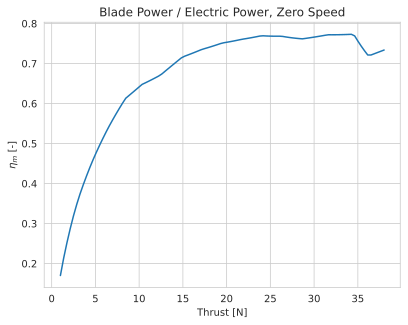

In [25]:
# calculate the measured efficiency (orange line over blue line above)
measured = interpolate.interp1d(x=df["Thrust (N)"], y=df["P"], kind="linear")
manuf = interpolate.interp1d(x=df_m_0s['Thrust (N)'], y=df_m_0s['PWR (W)'], kind="quadratic")
T = np.linspace(1, 38, 100)
plt.plot(T, manuf(T) / measured(T))
plt.title("Blade Power / Electric Power, Zero Speed")
plt.xlabel("Thrust [N]")
plt.ylabel(r"$\eta_m$ [-]")

Index(['rpm', 'V (mph)', 'J (Adv_Ratio)', 'Pe -', 'Ct -', 'Cp -', 'PWR (Hp)',
       'Torque (In-Lbf)', 'Thrust (Lbf)', 'PWR (W)', 'Torque (N-m)',
       'Thrust (N)', 'THR/PWR (g/W)', 'Mach -', 'Reyn -', 'FOM -', 'V (m/s)'],
      dtype='object')


/tmp/ipykernel_23865/3535449662.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return optimize.fsolve(


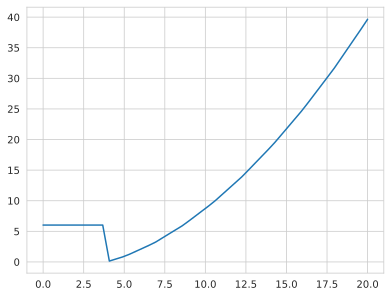

In [27]:
# two-dimensional interpolation of the manufacturer's data
# we take rpm and velocity as independent variables

points = np.array([df_manufacturer['rpm'].to_numpy(),
                  df_manufacturer['V (m/s)'].to_numpy()]).T

print(df_manufacturer.columns)

pe = interpolate.LinearNDInterpolator(
    points = points,
    values = df_manufacturer['Pe -'],
)

p = interpolate.LinearNDInterpolator(
    points = points,
    values = df_manufacturer['PWR (W)'],
)

T = interpolate.LinearNDInterpolator(
    points = points,
    values = df_manufacturer['Thrust (N)'],
)

Q_P = interpolate.LinearNDInterpolator(
    points = points,
    values = df_manufacturer['Torque (N-m)']
)

# an experiment to combine the analytic motor and the manufacturer prop relations

def get_rpm(throttle, speed):
    # speed in m/s
    # find the point where the prop torque equals the motor torque
    return optimize.fsolve(
        lambda rpm: c_42_60_06_torque(throttle, rpm[0]) - Q_P(np.array([[rpm[0], speed]])),
        5000
    )

# sns.lineplot(df, x="Throttle", y="Thrust (N)")
throttles = np.linspace(0, 20)
rpms = [get_rpm(t, 10)[0] for t in throttles]
thrusts = T(np.array([[rpm, 10] for rpm in rpms]))
plt.plot(throttles, thrusts)

/tmp/ipykernel_23865/3212286441.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  rpms_v_10 = [optimize.fsolve(lambda rpm: 1300 - p(np.array([[rpm[0], v]])), np.array([10000]),)[0] for v in v]


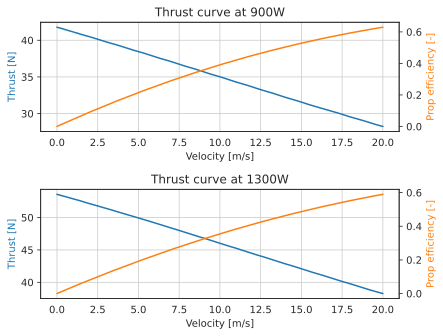

In [35]:
# calculate the takeoff thrust curve at different powers
v = np.linspace(0, 20, 100)
rpms_v = [optimize.fsolve(lambda rpm: 900 - p(np.array([[rpm[0], v]])), np.array([10000]),)[0] for v in v]
# print(rpms_v)
points_v = np.array(list(zip(rpms_v, v)))
T_v = T(points_v)
P_v = p(points_v)
pe_v = pe(points_v)
rpms_v_10 = [optimize.fsolve(lambda rpm: 1300 - p(np.array([[rpm[0], v]])), np.array([10000]),)[0] for v in v]
points_v_10 = np.array(list(zip(rpms_v_10, v)))
T_v_10 = T(points_v_10)
P_v_10 = p(points_v_10)
pe_v_10 = pe(points_v_10)
sns.set_style(style="white")
plt.subplot(211)
plt.plot(v, T_v, color="C0")
plt.xlabel("Velocity [m/s]")
plt.ylabel("Thrust [N]", color="C0")
plt.grid()
ax = plt.gca().twinx()
ax.plot(v, pe_v, color="C1")
ax.set_ylabel("Prop efficiency [-]", color="C1")
plt.title("Thrust curve at 900W")
plt.subplot(212)
plt.plot(v, T_v_10, color="C0")
plt.xlabel("Velocity [m/s]")
plt.ylabel("Thrust [N]", color="C0")
plt.grid()
ax = plt.gca().twinx()
ax.plot(v, pe_v_10,  color="C1")
ax.set_ylabel("Prop efficiency [-]", color="C1")
plt.title("Thrust curve at 1300W")
plt.tight_layout()
sns.set_style(style="whitegrid")

prop efficiency at operating point: 0.6966439056072535
prop power at operating point: 432.5970809325387 W


Text(0.5, 0, 'rpm')

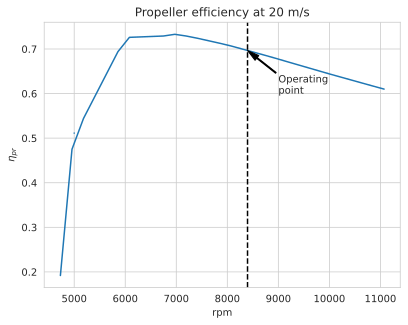

In [42]:
# operating point calculation
# drag at cruise is 15 N
optimize.fsolve(lambda rpm: 14.93 - T(np.array([[rpm[0], 20]])), [10000])
op = np.array([[8396, 20]])
print("prop efficiency at operating point:", pe(op)[0])
print("prop power at operating point:", p(op)[0], "W")

plt.plot(rpms, pe(np.array([[rpm, 20] for rpm in rpms])))
arrowprops = dict(
    color="k",
    width=1,
    headwidth=6
)
plt.axvline(8396, color="k", linestyle="--")
plt.title("Propeller efficiency at 20 m/s")
plt.ylabel(r"$\eta_{pr}$")
plt.annotate("Operating\npoint", xy=(8396, 0.6966), xytext=(9000, 0.6), arrowprops=arrowprops)
plt.xlabel("rpm")

Takeoff position, 900 W:  13.6657846820581 m
Takeoff position, 1300 W:  9.802270984941487 m


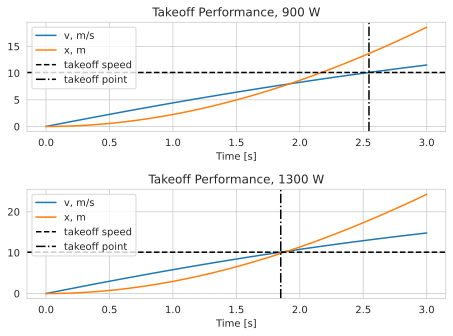

In [52]:
# ground roll calculation
# information taken from other notebook
CL = 0.8 # lift coeff
cd0 = 0.08 # zero lift drag coeff
m = 7.7 # mass
rho = 1.2 # air density
mur = 0.08 # ground coeff rolling resistance
b = 3.5 # wingspan
AR = 8.167 # aspect ratio
h = 0.5 # height off ground
e = 0.9 # oswald efficiency
k = 0.01 # airfoil related drag polar
g = 9.81 # acceleration due to gravity
S = b**2 / AR # wing area
def G(b, h):
    n = (16 * h / b)**2 
    return n / (1 + n)
G = G(b, h) # ground adjustment to induced drag
def K(k, G, e, AR):
    return G / (np.pi * e * AR) + k
K = K(k, G, e, AR) # drag polar
def Vlo(S, W, CL):
    rho = 1.23
    return np.sqrt(2 * W / (rho * S * CL)) 
Vlo = Vlo(S, m * g, CL) # lift-off velocity

# forces of takeoff
takeoff_T = interpolate.interp1d(v, T_v)
takeoff_T_10 = interpolate.interp1d(v, T_v_10)
takeoff_L = lambda v: 0.5 * rho * v**2 * S * CL
takeoff_D = lambda v: 0.5 * rho * v**2 * S * (cd0 + K*CL**2)
takeoff_R = lambda v: mur * (m * 9.81 - takeoff_L(v))

# equations of motion
def dvdt(t, y):
    x, v = y
    return np.array([v, (takeoff_T(v) - takeoff_D(v) - takeoff_R(v)) / m])

def dvdt_10(t, y):
    x, v = y
    return np.array([v, (takeoff_T_10(v) - takeoff_D(v) - takeoff_R(v)) / m])

t_span=[0,3]

res = integrate.solve_ivp(dvdt, t_span, np.array([0,0]), dense_output=True)
res_10 = integrate.solve_ivp(dvdt_10, t_span, np.array([0,0]), dense_output=True)




t = np.linspace(*t_span, 100)
for i, res in enumerate([res, res_10]):
    plt.subplot(211 + i)
    t_lo = optimize.fsolve(lambda t: res.sol(t[0])[1] - Vlo, np.array([2.5]))[0]
    plt.plot(t, res.sol(t)[1,:], label="v, m/s")
    plt.plot(t, res.sol(t)[0, :], label="x, m")
    plt.axhline(Vlo, color="k", linestyle="--", label="takeoff speed")
    plt.axvline(t_lo, color="k", linestyle="-.", label="takeoff point")
    plt.legend()
    pwr = "900 W" if i == 0 else "1300 W"
    print("Takeoff position, "+pwr+": ", res.sol(t_lo)[0], "m")
    plt.title("Takeoff Performance, " + pwr)
    plt.xlabel("Time [s]")

plt.tight_layout()